# TVB for Epilepsy


### Basic configurations

In [1]:
# !source activate python2.7.3
!source activate python2_7

%matplotlib inline

import resource 
resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))

import sys
stdout = sys.stdout

import os

import numpy as np
from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
# input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH")
# head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "notebook")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb") #, data_mode="java"
config.hypothesis.head_folder = head_folder
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
sys.stdout = stdout

# BASIC WORKFLOW 

### Read data from tvb or Head folder

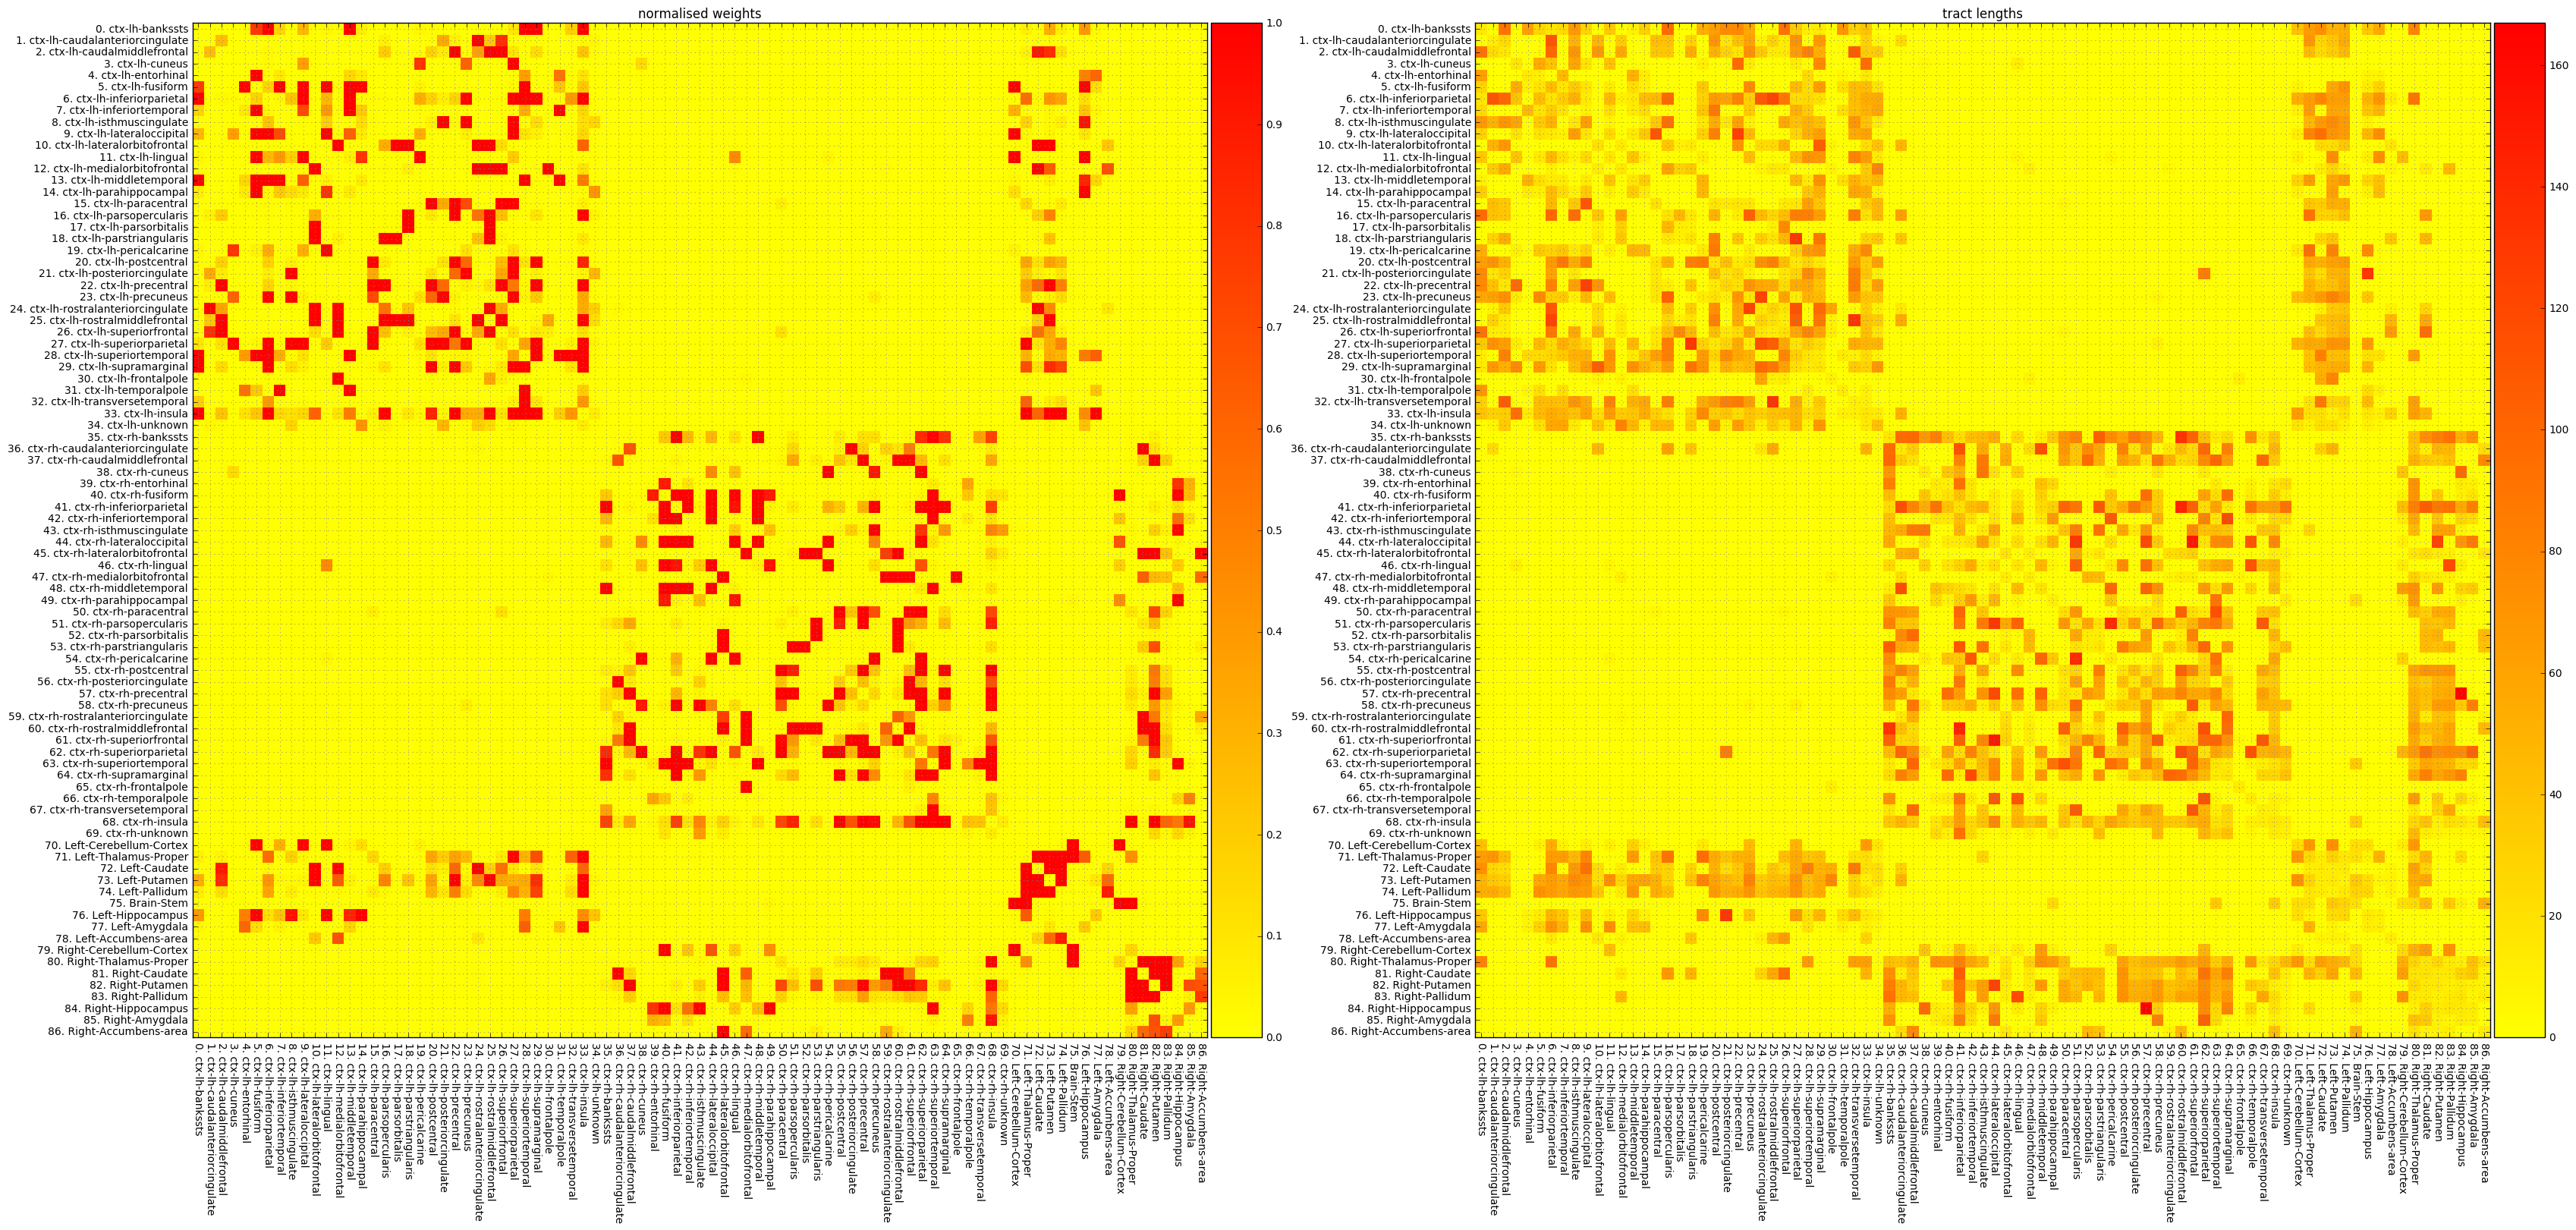

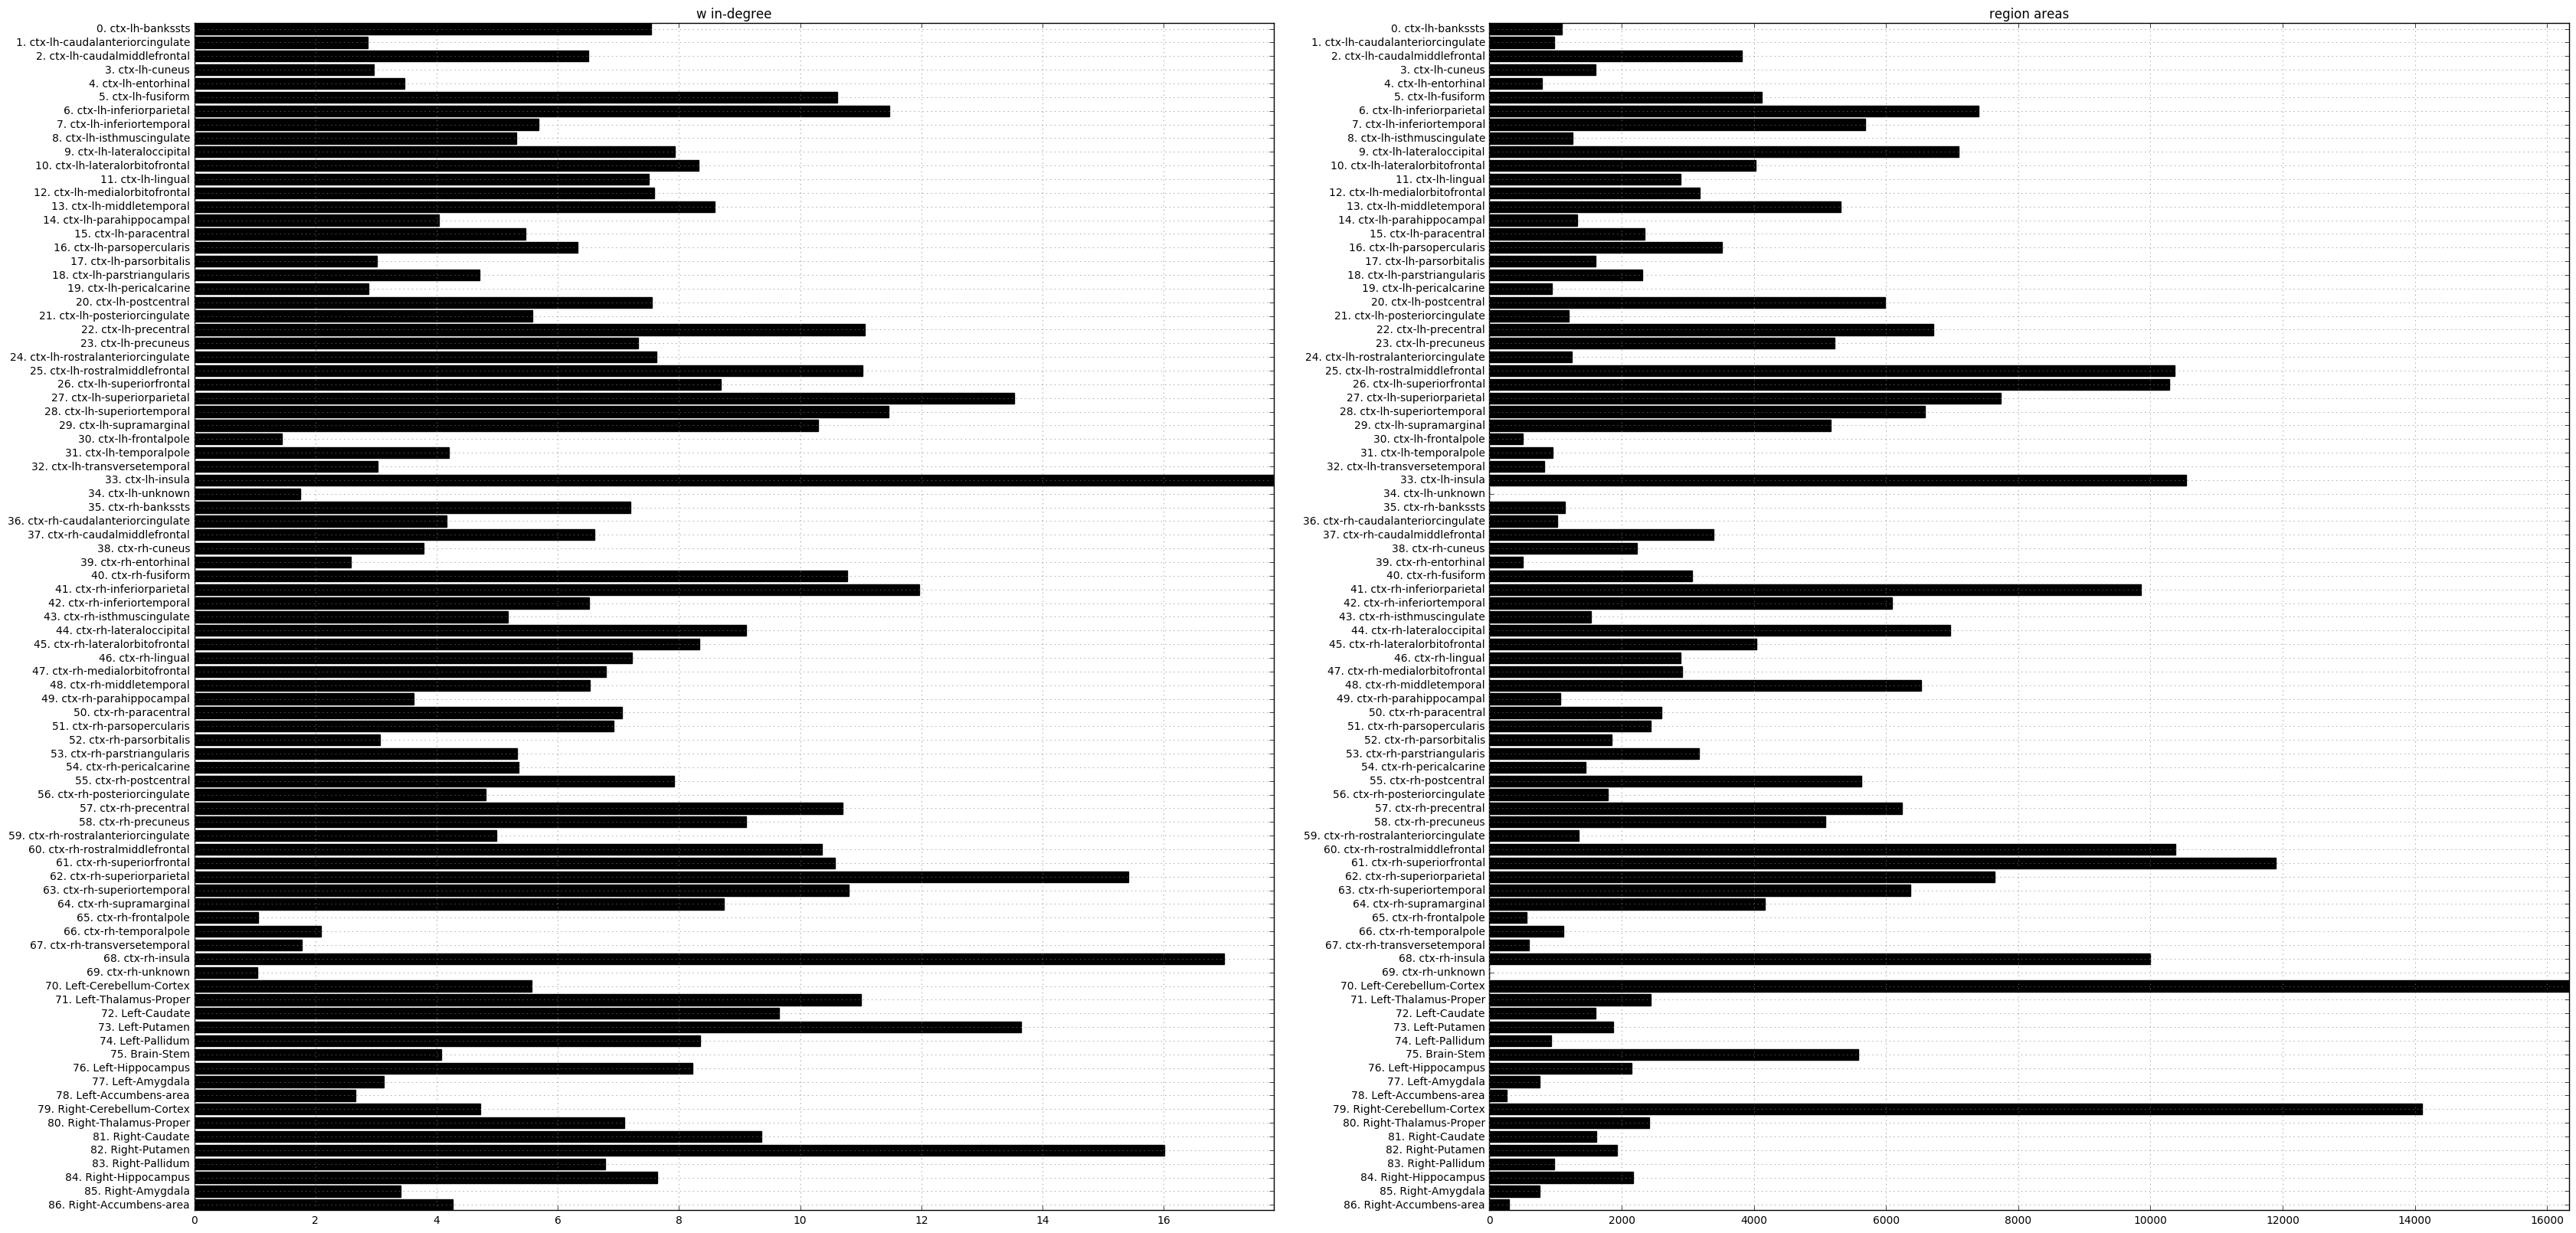

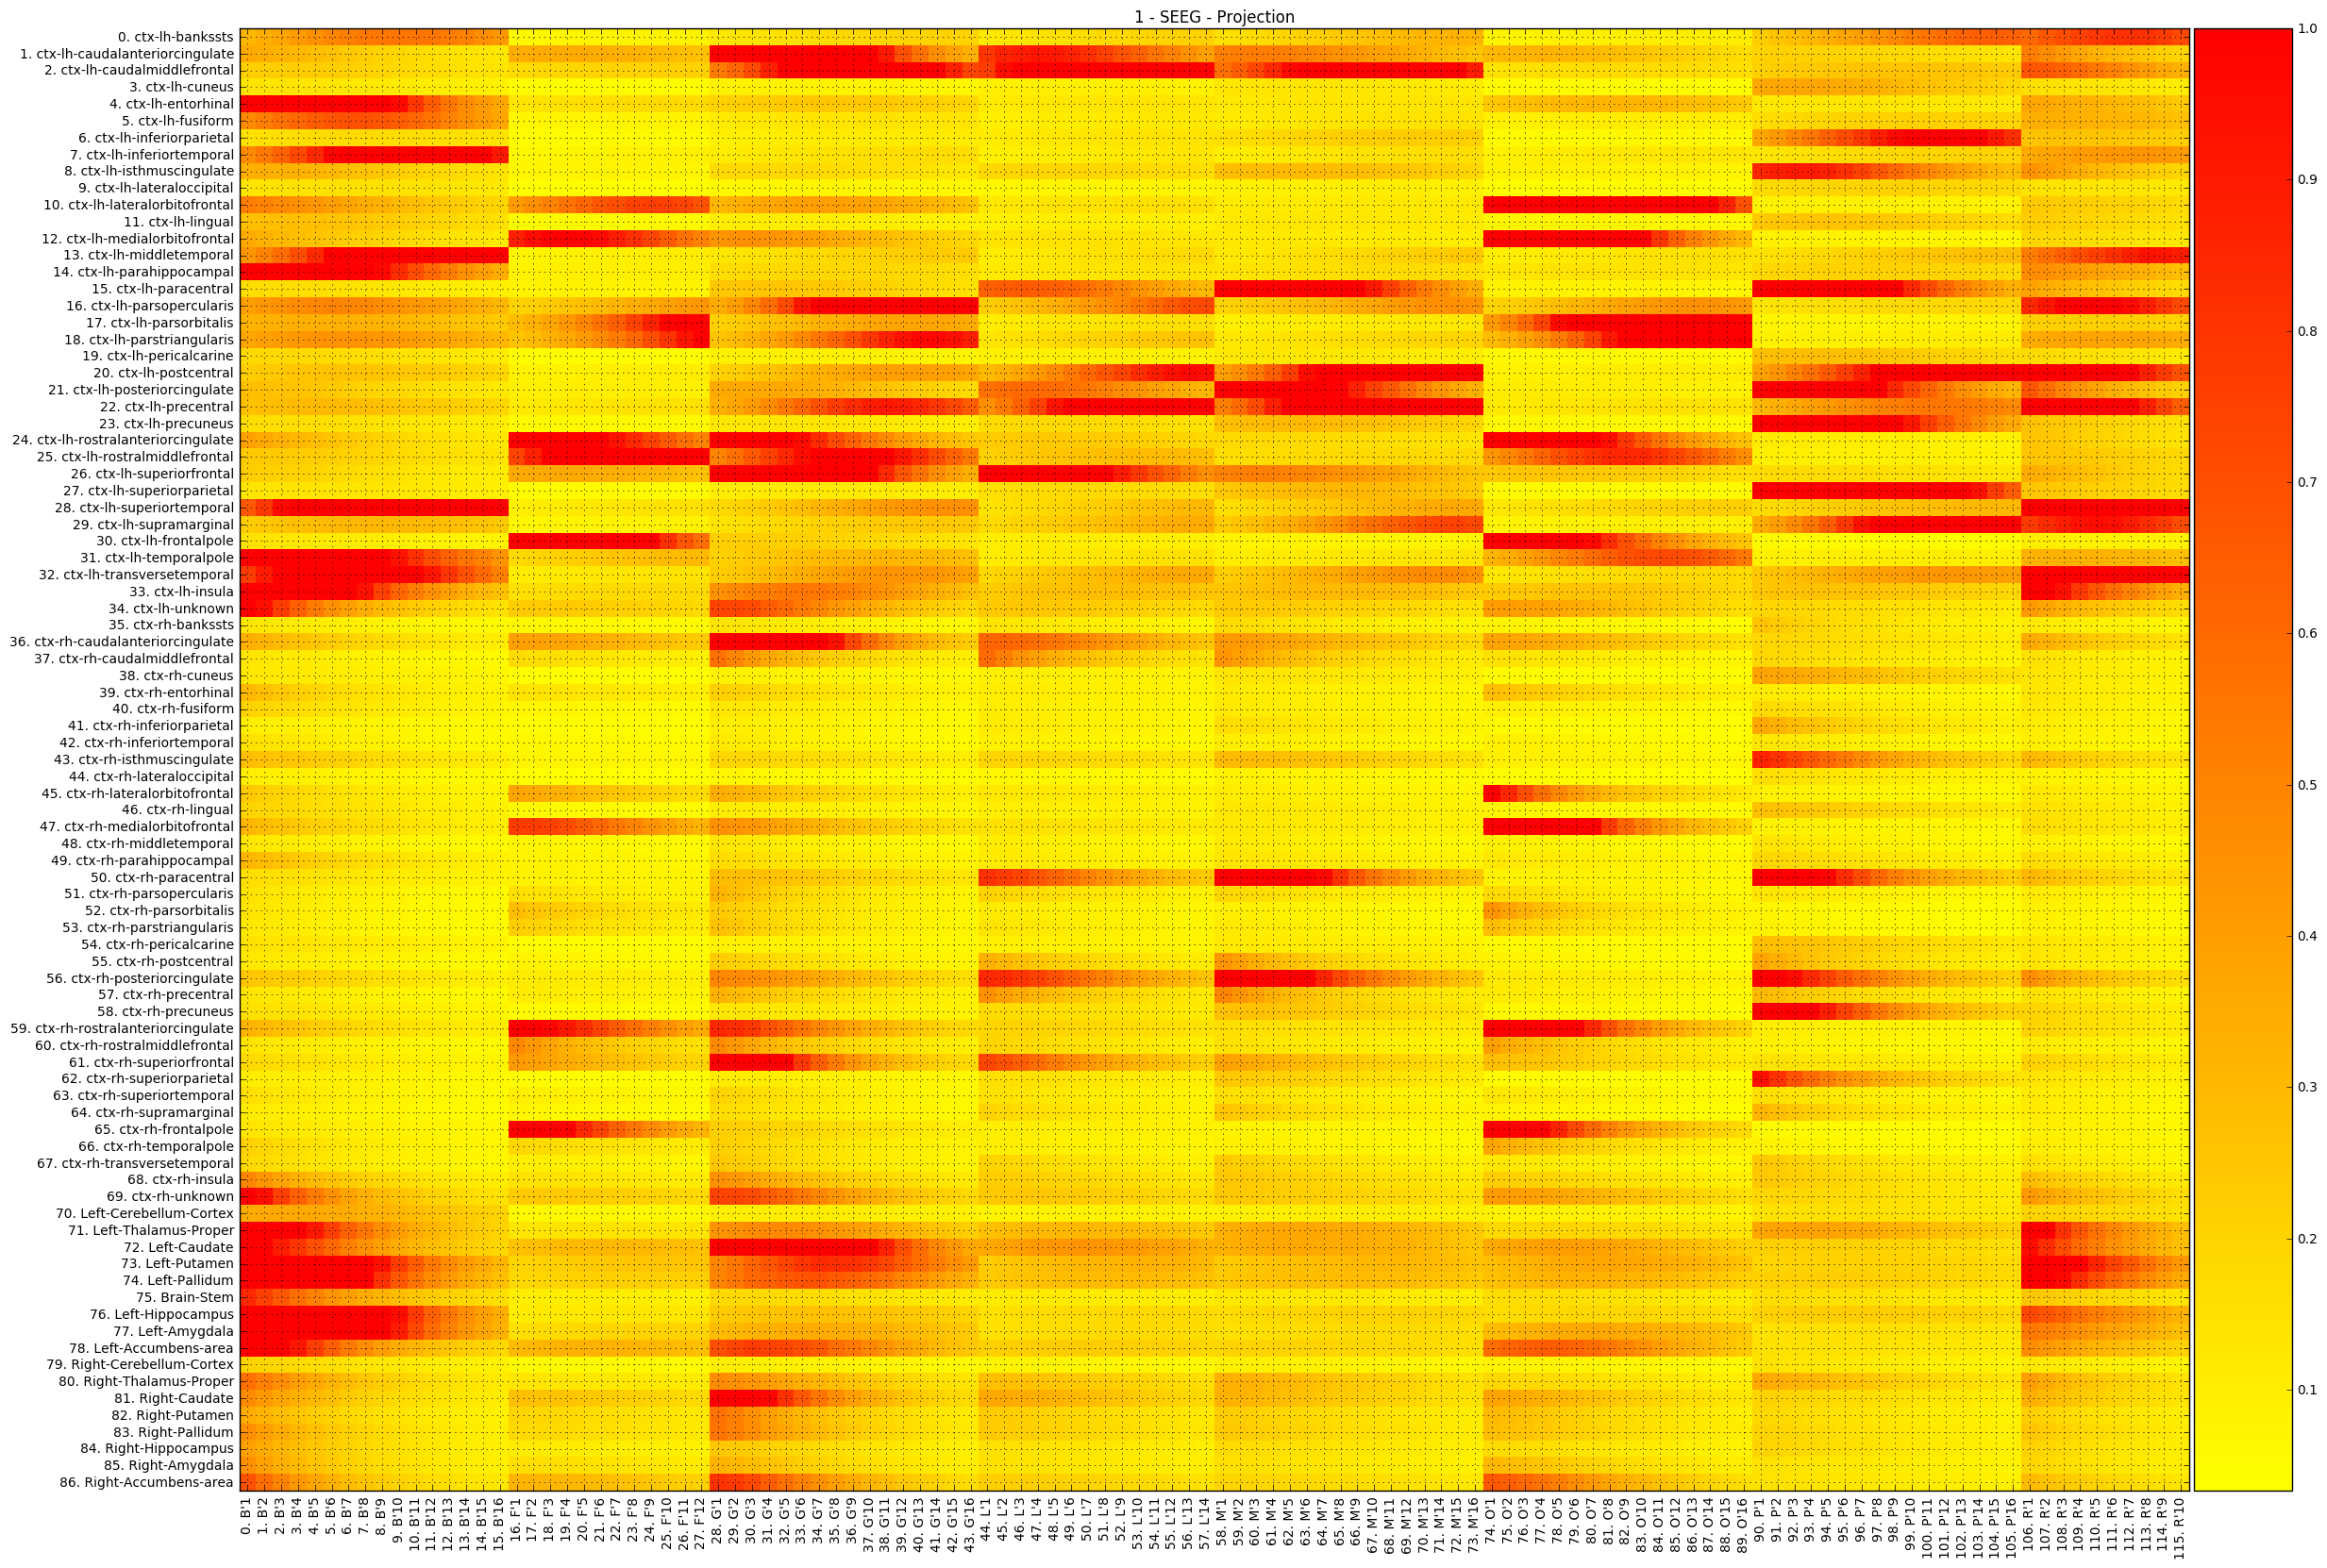

In [2]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD, seeg_sensors_files=[("seeg_xyz.txt",)])
# Plot
plotter.plot_head(head)

### Generate an hypothesis by manual definition 

In [3]:
# logger.info("\n\Reading hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(hypothesis_file)

# Formulate a VEP hypothesis manually
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)

# Regions of Pathological Excitability hypothesis:
x0_indices = [2, 25]
x0_values = [0.01, 0.01]
hyp_builder.set_x0_hypothesis(x0_indices, x0_values)

# Regions of Model Epileptogenicity hypothesis:
e_indices = list(range(head.connectivity.number_of_regions))
e_indices.remove(2)
e_indices.remove(25)
e_values = np.zeros((head.connectivity.number_of_regions, )) + 0.01
e_values[[1, 26]] = 0.99
e_values = np.delete(e_values, [2, 25]).tolist()
print(e_indices, e_values)
hyp_builder.set_e_hypothesis(e_indices, e_values)

# Regions of Connectivity hypothesis:
w_indices = [] # [(0, 1), (0, 2)] 
w_values = [] # [0.5, 2.0] 
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hyp_builder.build_hypothesis()

([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86], [0.01, 0.99, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])


### ...or by reading from epileptogenicity file...

In [ ]:
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
# Read clinical hypothesis 
hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)
e_indices = [1, 26]# [1, 2, 25, 26]
hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices) 
# Change something manually if necessary
hypothesis.x0_values = [0.01, 0.01]

### Print hypothesis

In [4]:
disease_indices = hypothesis.get_regions_disease_indices()
disease_values = hypothesis.get_regions_disease_values()
w_indices = hypothesis.get_connectivity_disease_indices()
w_values = hypothesis.get_connectivity_disease_values()
n_w = len(w_indices)
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
print(hypothesis)
print(hypothesis.string_regions_disease(head.connectivity.region_labels))
print(hypothesis.string_connectivity_disease(head.connectivity.region_labels))

DiseaseHypothesis{
07. Epileptogenicity (E) disease indices = [ 0.01  0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01]
05. Excitability (x0) disease values = [ 0.01  0.01]
04. Excitability (x0) disease indices = [2, 25]
09. Connectivity (W) disease values = []
02. Type = Excitability_Epileptogenicity
06. Epileptogenicity (E) disease indices = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5

### Generate model configuration from hypothesis

0: E=0.01
1: E=0.99
2: x0=0.01
3: E=0.01
4: E=0.01
5: E=0.01
6: E=0.01
7: E=0.01
8: E=0.01
9: E=0.01
10: E=0.01
11: E=0.01
12: E=0.01
13: E=0.01
14: E=0.01
15: E=0.01
16: E=0.01
17: E=0.01
18: E=0.01
19: E=0.01
20: E=0.01
21: E=0.01
22: E=0.01
23: E=0.01
24: E=0.01
25: x0=0.01
26: E=0.99
27: E=0.01
28: E=0.01
29: E=0.01
30: E=0.01
31: E=0.01
32: E=0.01
33: E=0.01
34: E=0.01
35: E=0.01
36: E=0.01
37: E=0.01
38: E=0.01
39: E=0.01
40: E=0.01
41: E=0.01
42: E=0.01
43: E=0.01
44: E=0.01
45: E=0.01
46: E=0.01
47: E=0.01
48: E=0.01
49: E=0.01
50: E=0.01
51: E=0.01
52: E=0.01
53: E=0.01
54: E=0.01
55: E=0.01
56: E=0.01
57: E=0.01
58: E=0.01
59: E=0.01
60: E=0.01
61: E=0.01
62: E=0.01
63: E=0.01
64: E=0.01
65: E=0.01
66: E=0.01
67: E=0.01
68: E=0.01
69: E=0.01
70: E=0.01
71: E=0.01
72: E=0.01
73: E=0.01
74: E=0.01
75: E=0.01
76: E=0.01
77: E=0.01
78: E=0.01
79: E=0.01
80: E=0.01
81: E=0.01
82: E=0.01
83: E=0.01
84: E=0.01
85: E=0.01
86: E=0.01
K = 5.74713
x0_max = 1.49024482585
x0_min = -3.1674

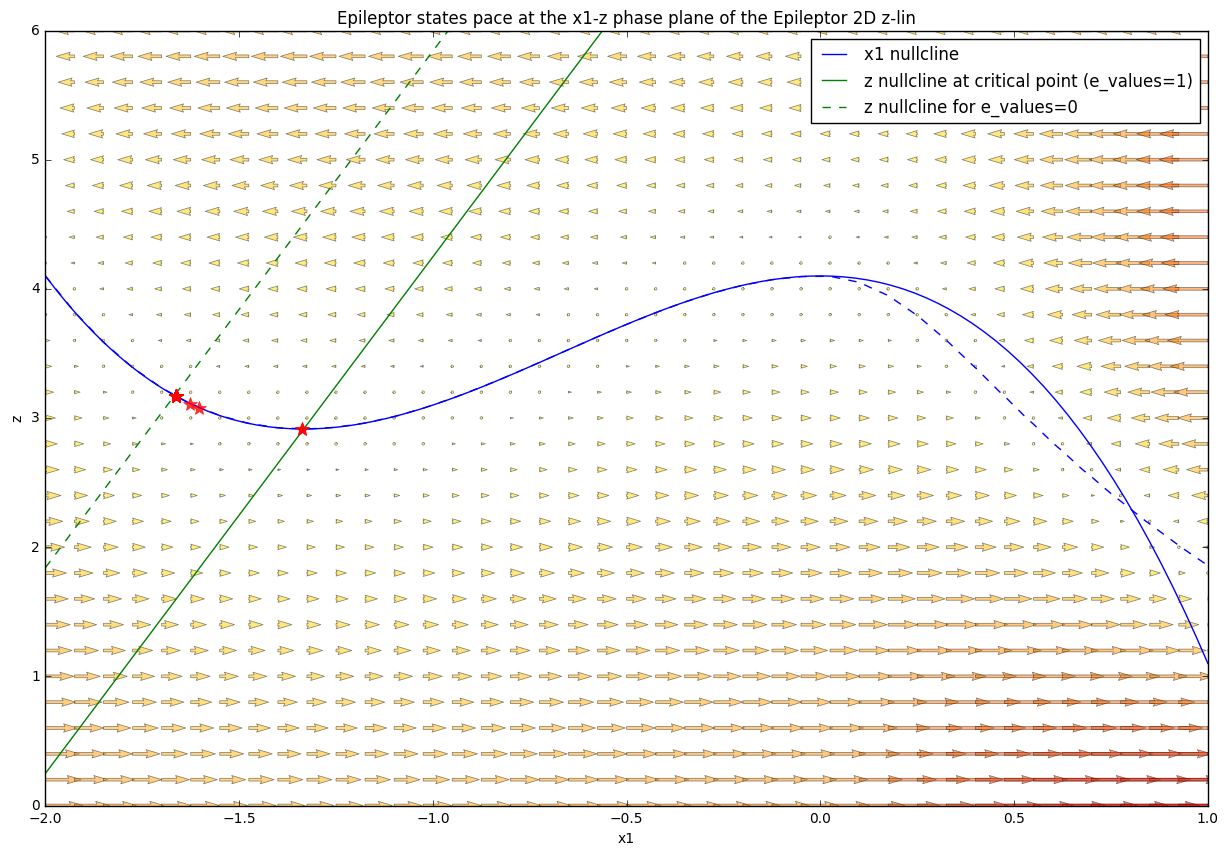

In [5]:
# logger.info("\n\nReading model configuration from file...")
# model_configuration = reader.read_model_configuration(model_config_file)

from tvb_epilepsy.service.model_configuration_builder import ModelConfigurationBuilder
from tvb_epilepsy.base.constants.model_constants import K_DEF

logger.info("\n\nRunning hypothesis: " + hypothesis.name)
logger.info("\n\nCreating model configuration...")
# K = 3*K_DEF # in the case of the above hypothesis read from file
K = 5*K_DEF # in the case of the above manual hypothesis
model_config_builder = ModelConfigurationBuilder(hypothesis.number_of_regions, K=K)
mcs_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_model_config_service.h5")
writer.write_model_configuration_builder(model_config_builder, mcs_file)
print(hypothesis.string_regions_disease())
# Assume all healthy nodes have x0_values = 0.0:
model_configuration = model_config_builder.build_model_from_hypothesis(hypothesis, head.connectivity.normalized_weights)
# # Assume all healthy nodes have e_values = 0.0
# model_configuration = model_config_builder.build_model_from_E_hypothesis(hypothesis, head.connectivity.normalized_weights)
print "K =", np.mean(model_configuration.K)
print "x0_max =", np.max(model_configuration.x0)
print "x0_min =", np.min(model_configuration.x0)
mc_path = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ModelConfig.h5")
writer.write_model_configuration(model_configuration, mc_path)
# Plot nullclines and equilibria of model configuration
plotter.plot_state_space(model_configuration, "2D", head.connectivity.region_labels, 
                         special_idx=hypothesis.x0_indices + hypothesis.e_indices, 
                         figure_name=hypothesis.name + "_StateSpace")

# LINEAR STABILITY ANALYSIS

### Run linear stability analysis

DiseaseHypothesis{
07. Epileptogenicity (E) disease indices = [ 0.01  0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01]
05. Excitability (x0) disease values = [ 0.01  0.01]
04. Excitability (x0) disease indices = [2, 25]
09. Connectivity (W) disease values = []
02. Type = Excitability_Epileptogenicity
06. Epileptogenicity (E) disease indices = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5

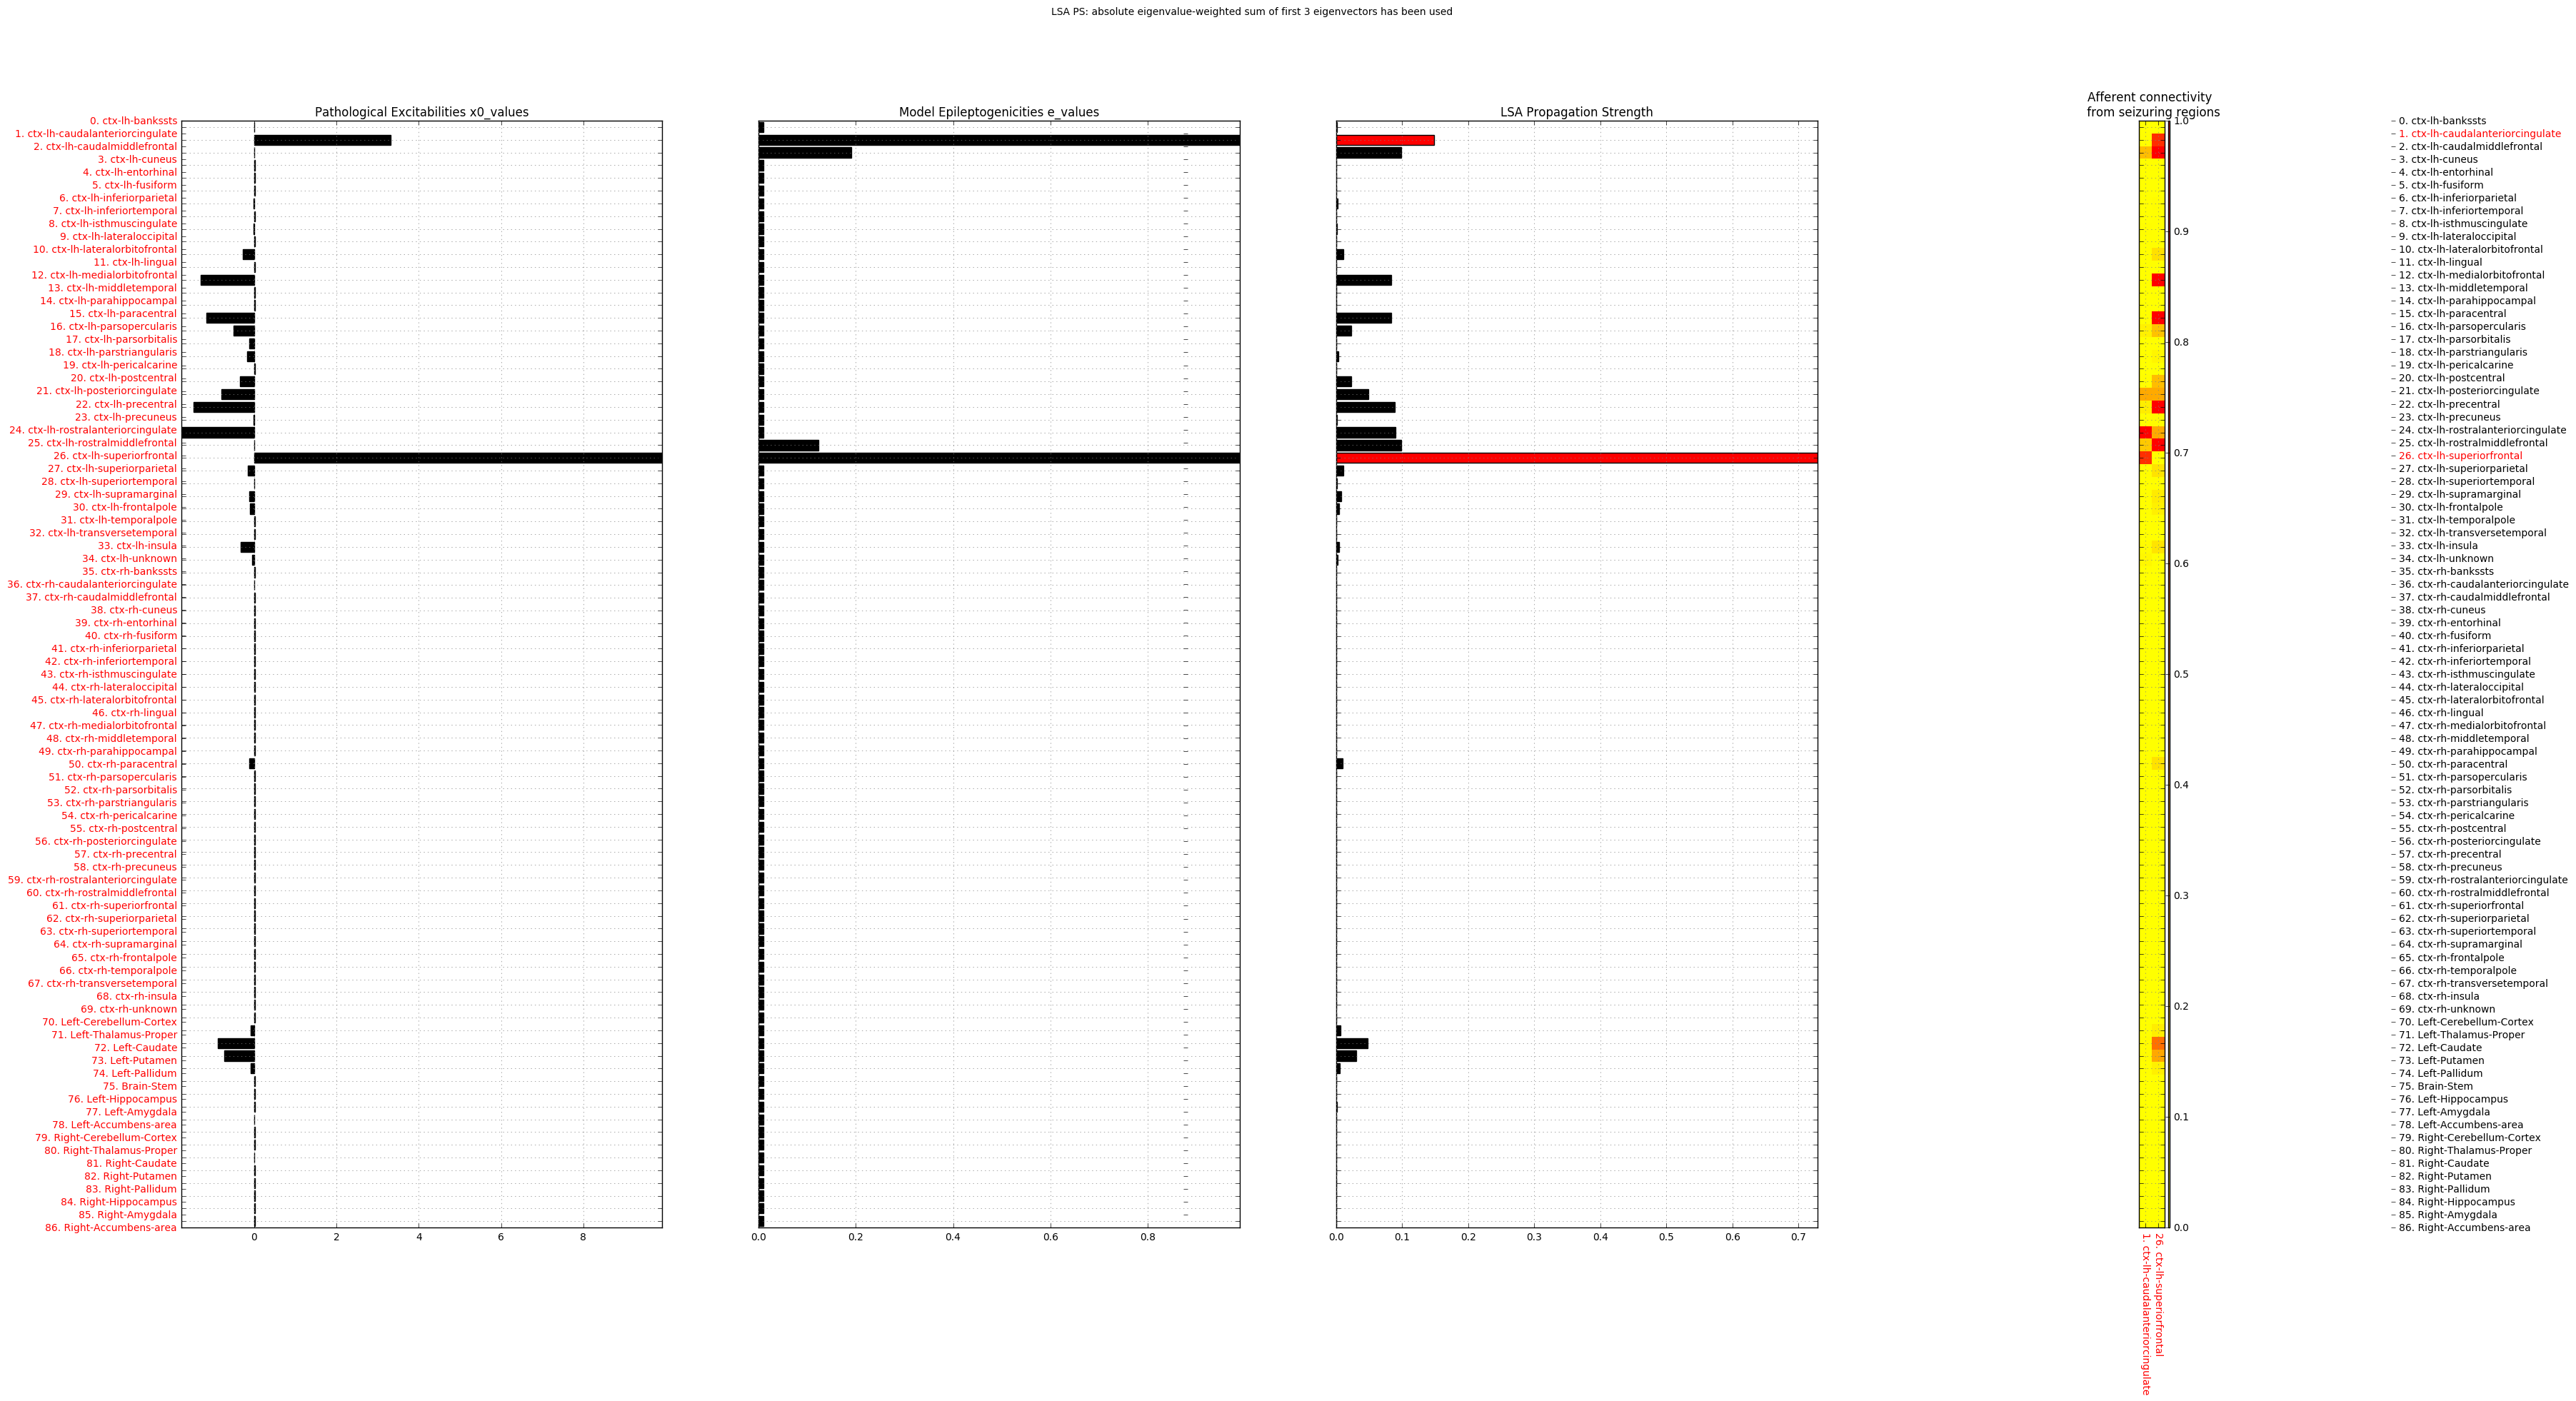

In [6]:
# Run linear stability analysis
# logger.info("\n\Reading LSA hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(lsa_hypothesis_file)
from tvb_epilepsy.service.lsa_service import LSAService
logger.info("\n\nRunning LSA...")
# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True, 
                         normalize_propagation_strength=False)
lsa_hypothesis = lsa_service.run_lsa(hypothesis, model_configuration)
print(lsa_hypothesis)
lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")
lsa_config_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
writer.write_hypothesis(lsa_hypothesis, lsa_path)

# Plot
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, None);


### Run parameter search exploration for linear stability analysis around the clinical hypothesis


Generated a parameter search exploration for lsa/sim task,
with 88 parameters of 100 values each,
leading to 100 total execution loops

Executing loop 1 of 100

Executing loop 10 of 100
2018-04-20 18:46:50,255 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[26]]  = [-1.33406484]
were corrected for LSA to value: X1EQ_CR_DEF - 10 ** (-3) = -1.33433333333 to be sub-critical!
2018-04-20 18:46:53,570 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[26]]  = [-1.3343153]
were corrected for LSA to value: X1EQ_CR_DEF - 10 ** (-3) = -1.33433333333 to be sub-critical!
2018-04-20 18:47:02,262 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[1]]  = [-1.33371341]
were corrected for LSA to value: X1EQ_CR_DEF - 10 ** (-3) = -1.33433333333 to be sub-critical!

Executing loop 20 of 100
2018-04-20 18:47:12,737 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1eq[[1]]  = [-1.33404112]
were corrected for LSA to value: X1EQ_CR_DEF - 10 ** (-3) = -1.33

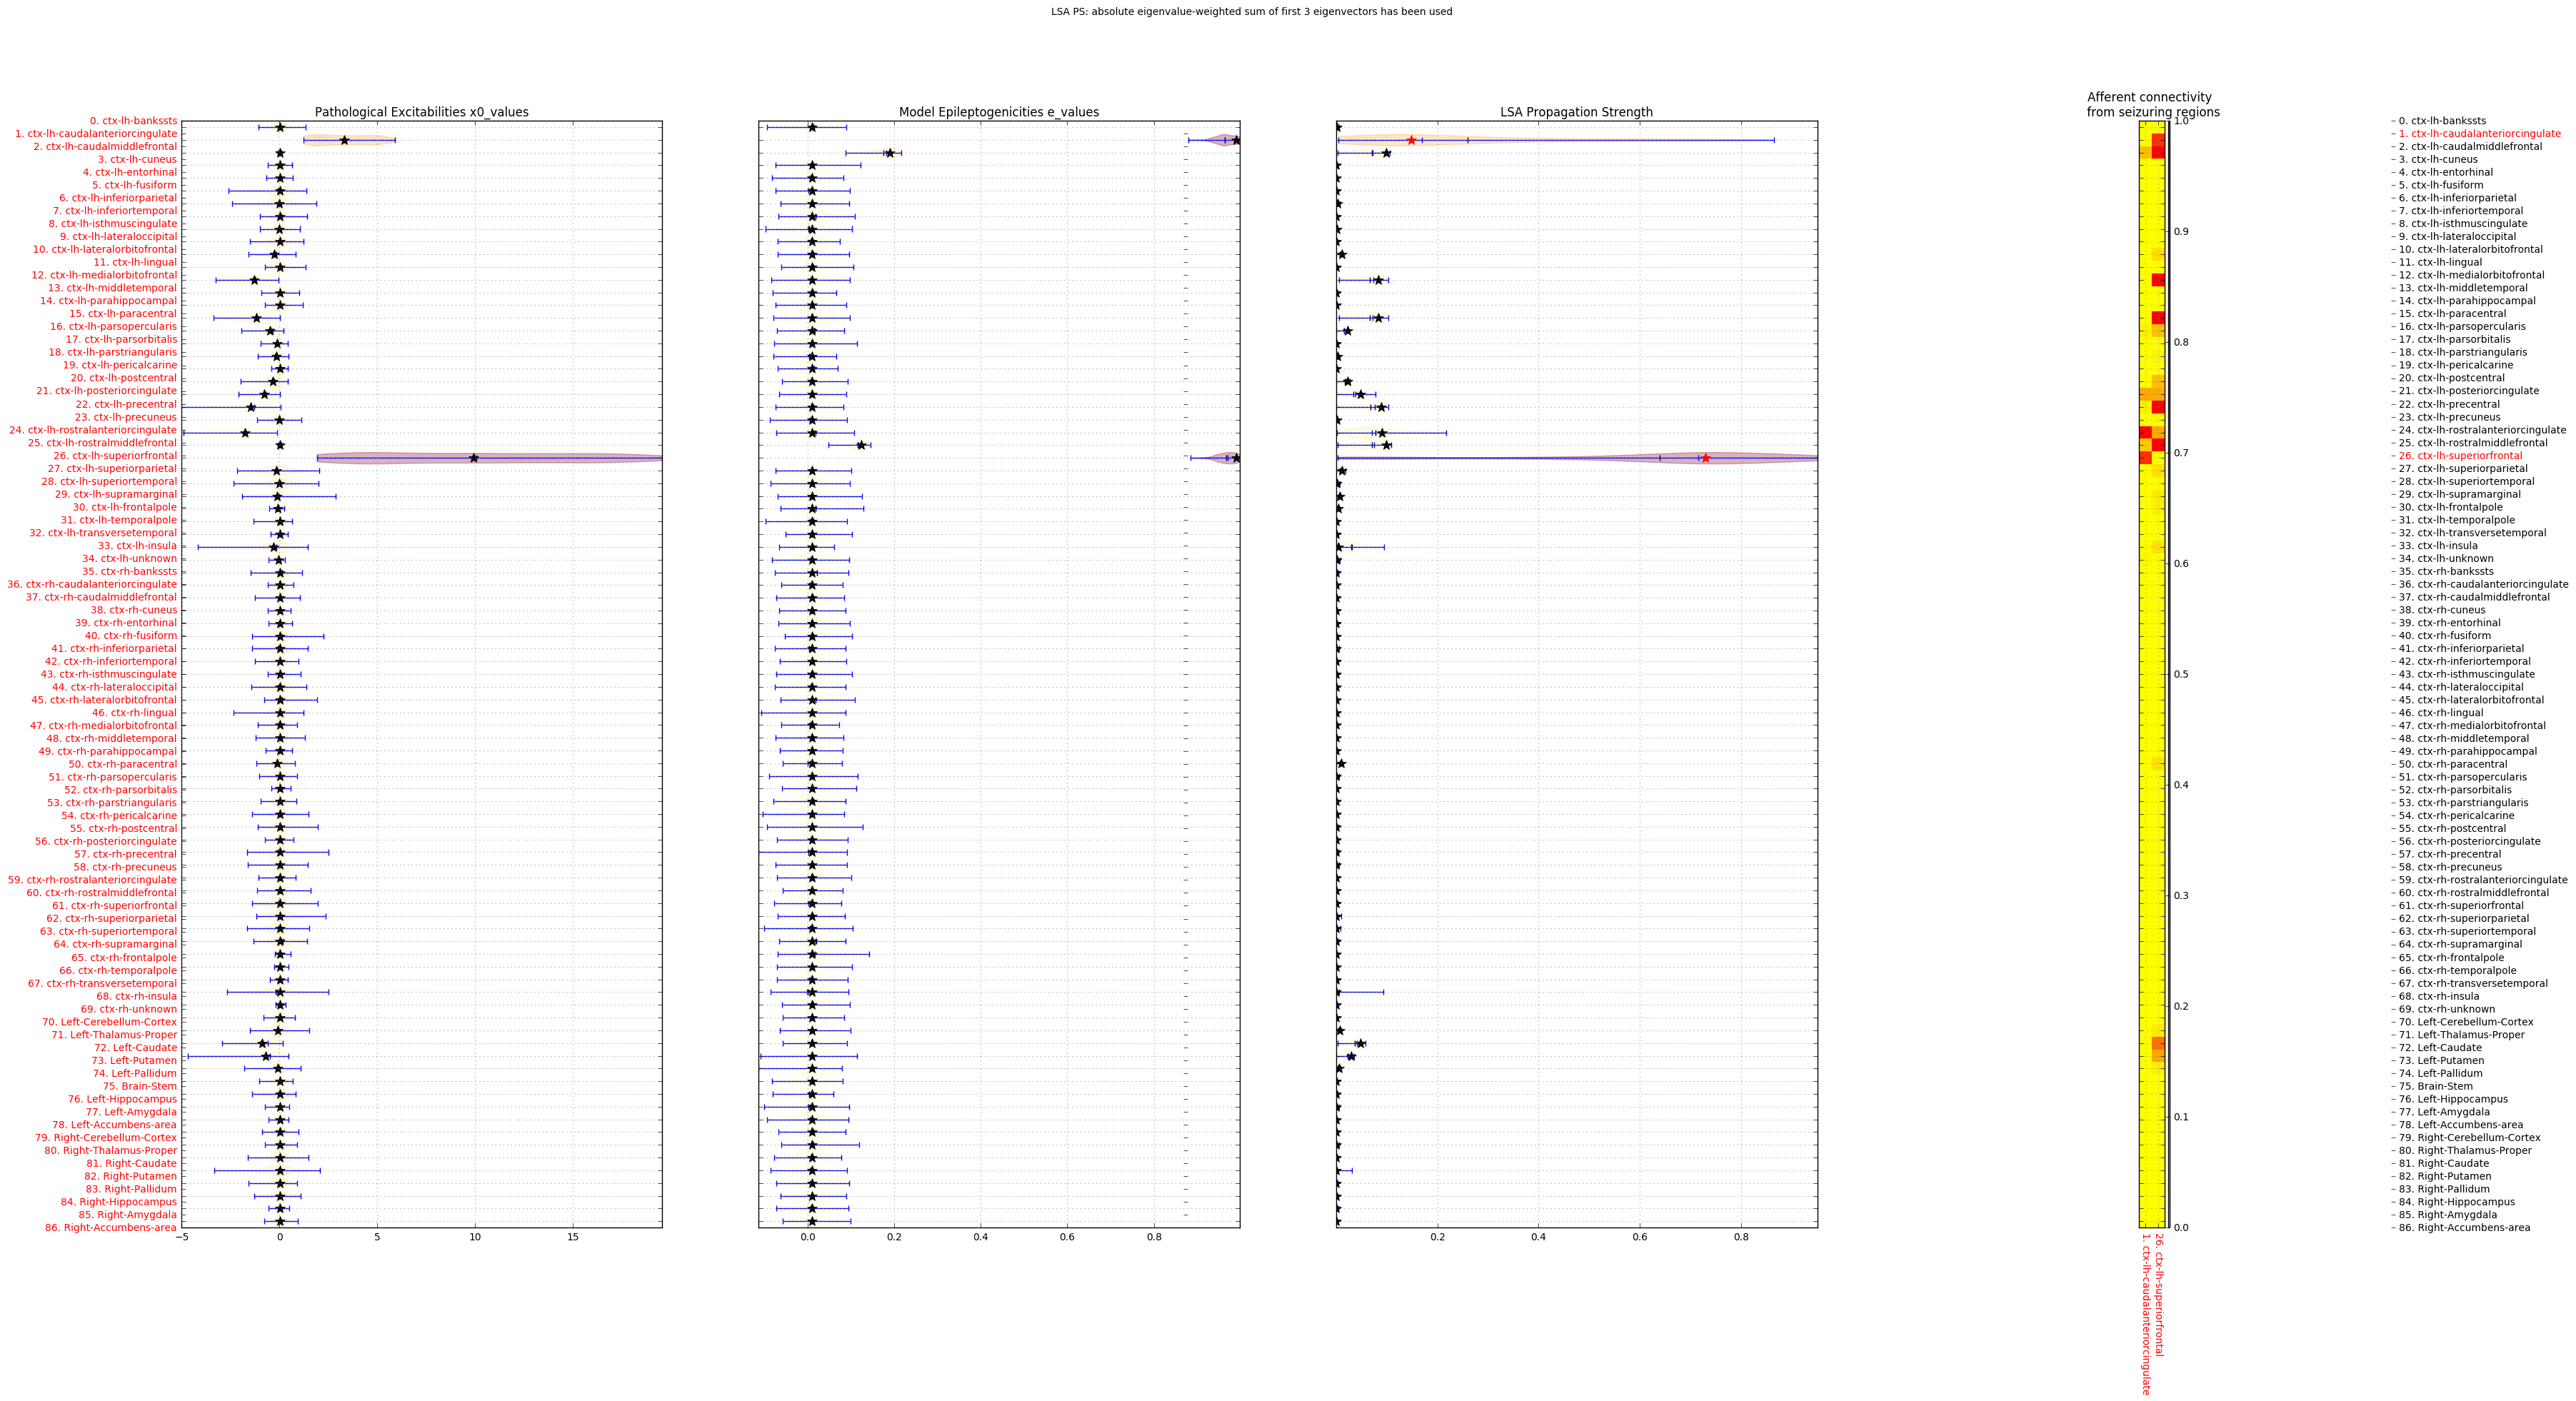

In [7]:
from tvb_epilepsy.top.scripts.pse_scripts import pse_from_lsa_hypothesis
# --------------Parameter Search Exploration (PSE)-------------------------------
logger.info("\n\nRunning PSE LSA...")
n_samples = 100
pse_results = pse_from_lsa_hypothesis(n_samples, lsa_hypothesis, 
                                      head.connectivity.normalized_weights,
                                      model_config_builder, lsa_service,
                                      head.connectivity.region_labels,
                                      param_range=0.1,
                                      global_coupling=[{"indices": all_regions_indices}],
                                      healthy_regions_parameters=[
                                                        {"name": "x0_values", "indices": healthy_indices}],
                                     logger=logger, save_flag=True)[0]
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, pse_results)

pse_lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_results.h5")
writer.write_dictionary(pse_results, pse_lsa_path)

# SIMULATION

### Prepare simulation

In [12]:
from collections import OrderedDict
from tvb_epilepsy.base.model.timeseries import Timeseries, TimeseriesDimensions
from tvb_epilepsy.service.simulator.simulator_builder import SimulatorBuilder
from tvb_epilepsy.top.scripts.simulation_scripts import compute_seeg_and_write_ts_to_h5

# --------------------------Simulation-----------------------------------
sim_type = "tvb" #"tvb" # "fitting"
logger.info("\n\nConfiguring simulation from model_configuration...")
# If you choose model...
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations,
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables,
#      -Iext2 and |slope are coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -multiplicative correlated noise is also used
# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0
sim_builder = SimulatorBuilder(config.simulator.MODE)
# sim_settings = reader.read_simulation_settings(sim_settings_file)
# First set model name, then build settings!
report_every_n_monitor_step=100
if sim_type == "realistic":
    model = sim_builder.set_model_name("EpileptorDPrealistic").generate_model_tvb(model_configuration)
    model.tau0 = 30000.0
    model.tau1 = 0.2
    model.slope = 0.25
    sim_settings = sim_builder.set_simulated_period(30000).build_sim_settings()
    from tvb_epilepsy.base.constants.model_constants import COLORED_NOISE
    sim_settings.noise_type = COLORED_NOISE
    sim_settings.noise_ntau = 10
    report_every_n_monitor_step=1000
elif sim_type == "fitting":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model_tvb(model_configuration)
    model.tau0 = 300.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(2048.0).set_simulated_period(2000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-5]
elif sim_type == "reduced":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model_tvb(model_configuration)
    model.tau0 = 2857.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(2048.0).set_simulated_period(5000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-7]
elif sim_type == "tvb":
   model = sim_builder.set_model_name("Epileptor").generate_model_tvb(model_configuration)
   sim_settings = sim_builder.set_simulated_period(5000).build_sim_settings()
else:
   model = sim_builder.generate_model(model_configuration)
   sim_settings = sim_builder.build_sim_settings()  # "EpileptorDP" by default

sim, sim_settings, model = sim_builder.build_simulator_TVB_from_model_sim_settings(model_configuration, 
                                                                                   head.connectivity, model, sim_settings)

writer.write_simulation_settings(sim.simulation_settings, os.path.join(config.out.FOLDER_RES, 
                                                                       lsa_hypothesis.name + "_SimSettings.h5"))
writer.write_generic(sim.model, os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_SimModel.h5"))


### SIMULATE!

In [ ]:
# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
logger.info("\n\nSimulating...")
sim_output = []
seeg=[]
sim_output, status = sim.launch_simulation(report_every_n_monitor_steps=100)
sim_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.model._ui_name + "_ts.h5")
if not status:
    logger.warning("\nSimulation failed!")
else:
    sim_output, seeg = \
        compute_seeg_and_write_ts_to_h5(sim_output, sim.model, head.sensorsSEEG, sim_ts_file,
                                        seeg_gain_mode="lin", hpf_flag=True, hpf_low=10.0, hpf_high=512.0)
     
    # Plot results 
    plotter.plot_simulated_timeseries(sim_output, sim.model, lsa_hypothesis.lsa_propagation_indices, 
                                      seeg_list=seeg, spectral_raster_plot=False, hpf_flag=False, log_scale=True)

...65.68359375% done in 58.7082979679 secs

# FITTING

### Basic configurations

In [ ]:
from tvb_epilepsy.base.constants.model_inversion_constants import *
from tvb_epilepsy.top.scripts.fitting_scripts import *

# TVB3 larger preselection of sensors:
sensors_lbls = [u"B'1", u"B'2", u"B'3", u"B'4",
                u"F'1", u"F'2", u"F'3", u"F'4", u"F'5", u"F'6", 
                    u"F'7", u"F'8", u"F'9", u"F'10", u"F'11",
                u"G'1", u"G'2", u"G'3", u"G'4", u"G'8", u"G'9", u"G'10", 
                    u"G'11", u"G'12", u"G'13", u"G'14", u"G'15",
                u"L'1", u"L'2", u"L'3", u"L'4", u"L'5", u"L'6", u"L'7",
                    u"L'8", u"L'9", u"L'10", u"L'11", u"L'12", u"L'13",
                u"M'1", u"M'2", u"M'3", u"M'7", u"M'8", u"M'9", u"M'10", 
                    u"M'11", u"M'12", u"M'13", u"M'14", u"M'15",
                u"O'1", u"O'2", u"O'3", u"O'6", u"O'7", u"O'8", u"O'9", 
                    u"O'10", u"O'11", u"O'12", # u"O'13"
                u"P'1", u"P'2", u"P'3", u"P'8", u"P'10", u"P'11", u"P'12", 
                    u"P'13", u"P'14", u"P'15", u"P'16",
                u"R'1", u"R'2", u"R'3", u"R'4", u"R'7", u"R'8", u"R'9",
         ]
sensors_inds = [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                26, 28, 29, 30, 31, 36, 37, 38, 39, 40, 41, 42,
                44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 
                58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72,
                74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 90, 91, 92, 
                97, 99, 100, 101, 102, 103, 104, 105,
                106, 107, 108, 109, 112, 113, 114]


### Initialize stan model and service

In [ ]:
from tvb_epilepsy.service.model_inversion.stan.cmdstan_service import CmdStanService
from tvb_epilepsy.service.model_inversion.stan.pystan_service import PyStanService

stan_model_name = "vep-fe-rev-09dp"
model_code_path = os.path.join(config.generic.STATS_MODELS_PATH, stan_model_name + ".stan")
fitmethod = "sample"
stan_service = CmdStanService(model_name=stan_model_name, model_code_path=model_code_path, 
                              fitmethod=fitmethod, config=config)
# stan_service = PyStanService(model_name=stan_model_name, model_code_path=model_code_path, 
#                              fitmethod=fitmethod, config=config)
stan_service.set_or_compile_model()

### Generate the Statistical Model

In [ ]:
from tvb_epilepsy.service.model_inversion.statistical_models_builders import SDEStatisticalModelBuilder
stats_model_file = os.path.join(config.out.FOLDER_RES, 
                                            hypothesis.name + "_StatsModel.h5")
statistical_model_builder = \
    SDEStatisticalModelBuilder(model_name="vep_sde", model_config=model_configuration,
                               parameters=
                                   [XModes.X0MODE.value, "sigma_"+XModes.X0MODE.value,
                                    "tau1", "tau0","K", "x1init", "zinit", "sigma_init", "sigma_eq",
                                    "sigma", "dX1t", "dZt", "epsilon", "scale", "offset"],
                               xmode=XModes.X0MODE.value, 
                               priors_mode=PriorsModes.NONINFORMATIVE.value,
                               sde_mode=SDE_MODES.NONCENTERED.value, 
                               observation_model=OBSERVATION_MODELS.SEEG_LOGPOWER.value)
statistical_model = statistical_model_builder.generate_model()
# or read one from existing file:
# statistical_model = reader.read_statistical_model(stats_model_file)

### Generate Model Inversion Service and select active regions

In [ ]:
from tvb_epilepsy.service.model_inversion.model_inversion_services import SDEModelInversionService
model_inversion = SDEModelInversionService()
# Update active model's active region nodes
statistical_model = 
    model_inversion.update_active_regions(statistical_model,
                                          e_values=lsa_hypothesis.e_values,
                                          lsa_propagation_strength=
                                                lsa_hypothesis.lsa_propagation_strengths,
                                          reset=True)

### Load and preprocess simulated data

In [ ]:
times_on_off=[1000.0, 19000.0]
# This is a script that loads simulated data or simulates if file doesn't exist
# and then, performs some signal preprocessing, identical to the one for empirical data
signals, simulator = \
     set_simulated_target_data(sim_ts_file, model_configuration, head, 
                               lsa_hypothesis, statistical_model,
                               0, times_on_off, plotter, config, 
                               title_prefix=hypothesis.name)
statistical_model.ground_truth.update({"tau1": np.mean(simulator.model.tt),
                                       "tau0": 1.0 / np.mean(simulator.model.r),
                                       "sigma": np.mean(simulator.simulation_settings.noise_intensity)})


### ...or load and preprocess empirical seeg data

In [ ]:
seizure = 'SZ1_0001.edf'
raw_empirical_file = os.path.join(config.input.RAW_DATA_FOLDER, seizure)
empirical_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.model._ui_name + "_ts_empirical.h5")
# This is a script that loads empirical data and preprocesses them from edf file
# label_strip_fun: optional argument to get labels from edf file
times_on_off = [15.0, 35.0] * 1000
signals = 
    set_empirical_data(empirical_file, empirical_ts_file,
                       head, sensors_lbls, sensors_id, times_on_off,
                       label_strip_fun=lambda s: s.split("POL ")[-1],
                       plotter=plotter, title_prefix=hypothesis.name)

### Select empirical data (sensors or regions) to fit

In [ ]:
if statistical_model.observation_model in OBSERVATION_MODELS.SEEG.value:
    model_inversion.auto_selection = "correlation-power"
    model_inversion.sensors_per_electrode = 2
target_data, statistical_model, gain_matrix = \
    model_inversion.set_target_data_and_time(signals, statistical_model, 
                                             head=head, sensors=head.get_sensors_id(0))

### Plot (and write to file) statistical model and target data

In [ ]:
plotter.plot_statistical_model(statistical_model, hyp.name + " Statistical Model")
plotter.plot_raster({'Target Signals': target_data.squeezed}, target_data.time_line,
                    time_units=target_data.time_unit, title=hypothesis.name + ' Target Signals raster',
                    offset=0.1, labels=target_data.space_labels)
plotter.plot_timeseries({'Target Signals': target_data.squeezed}, target_data.time_line,
                        time_units=target_data.time_unit, title=hypothesis.name + ' Target Signals', 
                        labels=target_data.space_labels)

writer.write_statistical_model(statistical_model, model_configuration.number_of_regions, stats_model_file)
writer.write_timeseries(target_data, target_data_file)

### Generate stan model data (.R) 

In [ ]:
model_data = 
    build_stan_model_dict_to_interface_ins(statistical_model, target_data.squeezed,
                                           gain_matrix, time=target_data.time_line)
writer.write_dictionary(model_data, model_data_file)

### FIT!

In [ ]:
estimates, samples, summary = stan_service.fit(debug=0, simulate=0, model_data=model_data, merge_outputs=False,
                                               chains=2, refresh=1, num_warmup=num_warmup, num_samples=30,
                                              max_depth=10, delta=0.8, save_warmup=1, plot_warmup=1, **kwargs)
writer.write_generic(estimates, os.path.join(config.out.FOLDER_RES, 
                                             hypothesis.name + stan_model_name + "_FitEst.h5"))
writer.write_generic(samples, os.path.join(config.out.FOLDER_RES, 
                                          hypothesis.name + "_" + stan_model_name + "_FitSamples.h5"))
if summary is not None:
    writer.write_generic(summary, pos.path.join(config.out.FOLDER_RES, 
                                          hypothesis.name + "_" + stan_model_name + "_FitSummary.h5"))
else:
    ests, samples, summary = stan_service.read_output()
    if fitmethod.find("sampl") >= 0:
        plotter.plot_HMC(samples, skip_samples=num_warmup, 
                         figure_name=hypothesis.name + "_" + stan_model_name + " HMC NUTS trace")

### Get, convert, plot fitting results...

In [ ]:
estimates, samples, Rhat, model_data = 
    convert_params_names_from_ins([estimates, samples, 
                                   stan_service.get_Rhat(summary), model_data])

# Pack fit samples time series into timeseries objects:
samples, target_data = samples_to_timeseries(samples, model_data, target_data, head.connectivity.region_labels)

plotter.plot_fit_results(estimates, samples, model_data, target_data, statistical_model, stats={"Rhat": Rhat},
                         pair_plot_params=["tau1", "K", "sigma", "epsilon", "scale", "offset"],
                         region_violin_params=["x0", "x1init", "zinit"], regions_mode="active",
                         regions_labels=head.connectivity.region_labels, trajectories_plot=True,
                         connectivity_plot=False, skip_samples=num_warmup, title_prefix=hyp.name)

### Generate a new model configuration from each one of the chains'results

In [ ]:
for id_est, est in enumerate(ensure_list(estimates)):
    fit_model_configuration_builder = 
        ModelConfigurationBuilder(hyp.number_of_regions, K=est["K"] * hyp.number_of_regions)
    x0_values_fit = model_configuration.x0_values
    x0_values_fit[statistical_model.active_regions] = \
        fit_model_configuration_builder._compute_x0_values_from_x0_model(est['x0'])
    hyp_fit = HypothesisBuilder().\
                  set_nr_of_regions(head.connectivity.number_of_regions).\
                      set_name('fit' + str(id_est) + "_" + hyp.name).\
                          set_x0_hypothesis(list(statistical_model.active_regions),
                                            x0_values_fit[statistical_model.active_regions]).\
                              build_hypothesis()
    writer.write_hypothesis(hyp_fit, os.path.join(config.out.FOLDER_RES, hyp_fit.name + ".h5"))
    model_configuration_fit = \
        fit_model_configuration_builder.build_model_from_hypothesis(hyp_fit,  # est["MC"]
                                                                    model_configuration.model_connectivity)
    writer.write_model_configuration(model_configuration_fit, os.path.join(config.out.FOLDER_RES, 
                                                                           hyp_fit.name + "_FitModelConfig.h5"))

    # Plot nullclines and equilibria of fit model configuration
    plotter.plot_state_space(model_configuration_fit, region_labels=head.connectivity.region_labels,
                             special_idx=statistical_model.active_regions, model="6d", zmode="lin",
                             figure_name=hyp_fit.name + "_Nullclines and equilibria")